In [1]:
"""
This file contains the code to run experiments with artificial soft labels.

The experiment is:
    * Train a soft label predictor model on CIFAR-10H
    * Generate artificial soft labels for CIFAR-10
    * Train a model on CIFAR-10 with the artificial soft labels + CIFAR-10H
    * Evaluate the model on CIFAR-10
"""

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from typing import Tuple, Dict, List
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from generate_soft_labels import create_soft_label_dataset
from soft_label_predictor import ImageHardToSoftLabelModel
import os
import json
from sklearn.metrics import precision_recall_curve, average_precision_score

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

In [2]:
def plot_training_curves(metrics: Dict[str, List[float]], title: str = "Training Curves"):
    """Plot training and validation metrics over epochs."""
    plt.figure(figsize=(12, 4))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Acc')
    plt.plot(metrics['val_acc'], label='Val Acc')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [3]:
def save_metrics(metrics: Dict, model_name: str):
    """Save metrics dictionary to JSON file."""
    metrics_path = f"metrics/{model_name}_metrics.json"
    os.makedirs("metrics", exist_ok=True)
    
    # Convert numpy arrays and tensors to lists for JSON serialization
    serializable_metrics = {}
    for key, value in metrics.items():
        if isinstance(value, (np.ndarray, torch.Tensor)):
            serializable_metrics[key] = value.tolist()
        elif isinstance(value, list):
            serializable_metrics[key] = [v.item() if isinstance(v, (np.ndarray, torch.Tensor)) else v for v in value]
        else:
            serializable_metrics[key] = value
    
    with open(metrics_path, 'w') as f:
        json.dump(serializable_metrics, f)

def plot_comparative_curves(all_metrics: Dict[str, Dict], title: str = "Comparative Training Curves"):
    """Plot training curves for multiple models on the same graph."""
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    for model_name, metrics in all_metrics.items():
        plt.plot(metrics['train_loss'], label=f'{model_name} Train')
        plt.plot(metrics['val_loss'], label=f'{model_name} Val', linestyle='--')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    for model_name, metrics in all_metrics.items():
        plt.plot(metrics['train_acc'], label=f'{model_name} Train')
        plt.plot(metrics['val_acc'], label=f'{model_name} Val', linestyle='--')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig('comparative_curves.png')
    plt.show()

def compute_additional_metrics(all_preds, all_labels, all_probs):
    """Compute additional metrics including AUPRC."""
    metrics = {}
    
    # Compute precision, recall, and F1 for each class
    for i in range(10):
        binary_labels = (np.array(all_labels) == i).astype(int)
        binary_probs = np.array(all_probs)[:, i]
        
        precision, recall, _ = precision_recall_curve(binary_labels, binary_probs)
        auprc = average_precision_score(binary_labels, binary_probs)
        
        metrics[f'class_{CIFAR10_CLASSES[i]}_auprc'] = auprc
    
    # Compute macro-averaged metrics
    metrics['macro_auprc'] = np.mean([metrics[f'class_{c}_auprc'] for c in CIFAR10_CLASSES])
    
    return metrics

def evaluate_metrics(model, test_loader, device, classes=CIFAR10_CLASSES):
    """Evaluate model performance with detailed metrics."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            if len(labels.shape) > 1:  # For soft labels
                _, predicted = torch.max(outputs.data, 1)
                _, true_labels = torch.max(labels, 1)
            else:  # For hard labels
                _, predicted = torch.max(outputs.data, 1)
                true_labels = labels
                
            total += labels.size(0)
            correct += (predicted == true_labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate basic metrics
    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    
    # Calculate additional metrics
    additional_metrics = compute_additional_metrics(all_preds, all_labels, all_probs)
    
    report = classification_report(all_labels, all_preds, 
                                                    target_names=classes if classes else None,
                                                    output_dict=True)
    
    # Print summary of metrics
    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%") 
    print(f"Macro AUPRC: {additional_metrics['macro_auprc']:.4f}")
    print(report)

    
    # Combine all metrics
    metrics = {
        'test_loss': avg_loss,
        'test_accuracy': accuracy,
        **additional_metrics,
        'classification_report': report
    }
    
    return metrics

In [4]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    device: str = None,
    learning_rate: float = 0.001,
    weight_decay: float = 0.01,
    model_name: str = None,
) -> Tuple[nn.Module, Dict]:
    if device is None:
        device = torch.device(
            "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        )
    print(f"Training on {device}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    metrics = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if len(labels.shape) > 1:  # For soft labels
                _, predicted = torch.max(outputs.data, 1)
                _, true_labels = torch.max(labels, 1)
            else:  # For hard labels
                _, predicted = torch.max(outputs.data, 1)
                true_labels = labels
                
            train_total += labels.size(0)
            train_correct += (predicted == true_labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                if len(labels.shape) > 1:  # For soft labels
                    _, predicted = torch.max(outputs.data, 1)
                    _, true_labels = torch.max(labels, 1)
                else:  # For hard labels
                    _, predicted = torch.max(outputs.data, 1)
                    true_labels = labels
                    
                val_total += labels.size(0)
                val_correct += (predicted == true_labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # Store metrics
        metrics['train_loss'].append(avg_train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['val_loss'].append(avg_val_loss)
        metrics['val_acc'].append(val_acc)
        
        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
            f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%"
        )

        # Save model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if model_name:
                torch.save(model.state_dict(), f"models/{model_name}.pth")
                print(f"Saved model with improved validation accuracy: {val_acc:.2f}%")

    # Plot training curves
    plot_training_curves(metrics, title=f"Training Curves - {model_name if model_name else 'Model'}")
    
    return model, metrics

In [5]:
class CIFAR10LabelDataset(Dataset):
    def __init__(self, dataset, soft_labels=None):
        self.dataset = dataset
        self.soft_labels = soft_labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.soft_labels is None:
            # Convert hard labels to one-hot
            label = F.one_hot(torch.tensor(label), num_classes=10).float()
        else:
            label = torch.tensor(self.soft_labels[idx])
        return image, label
    
# Load CIFAR-10 dataset and return train, validation, and test DataLoaders
def load_cifar10_experiment():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
    ])
    
    full_dataset = datasets.CIFAR10(root="../data/cifar-10", train=True, download=True, transform=transform)
    train_dataset = datasets.CIFAR10(root="../data/cifar-10", train=False, download=True, transform=transform)

    # Split full dataset into augment, test, and validation sets
    augment_size = int(0.7 * len(full_dataset))
    val_size = (len(full_dataset) - augment_size) // 2
    test_size = len(full_dataset) - augment_size - val_size
    
    augment_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [augment_size, test_size, val_size], 
        generator=torch.Generator().manual_seed(229)
    )

    return augment_dataset, train_dataset, test_dataset, val_dataset

In [6]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)
print(f"Using device: {device}")

# Load datasets
augment_dataset, train_dataset, test_dataset, val_dataset = load_cifar10_experiment()

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
augment_loader = DataLoader(augment_dataset, batch_size=batch_size, shuffle=False)

# Load CIFAR-10H soft labels
cifar10h_probs = np.load("../data/cifar-10h/cifar10h-probs.npy").astype(np.float32)

print(f"CIFAR-10 dataset loaded with {len(augment_dataset)} augment samples, {len(train_dataset)} training samples, {len(test_dataset)} testing samples, and {len(val_dataset)} validation samples")
print(f"CIFAR-10H soft labels loaded with shape {cifar10h_probs.shape}")

all_metrics = {}

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset loaded with 35000 augment samples, 10000 training samples, 7500 testing samples, and 7500 validation samples
CIFAR-10H soft labels loaded with shape (10000, 10)



=== Running Main Experiment ===
Training with artificial soft labels + CIFAR-10H
Combined soft dataset size: 45000 samples
- Augmented soft labels: 35000 samples
- CIFAR-10H soft labels: 10000 samples
Training on cuda
Epoch [1/30] Train Loss: 1.0100, Val Loss: 1.0177, Train Acc: 68.74%, Val Acc: 64.17%
Saved model with improved validation accuracy: 64.17%
Epoch [2/30] Train Loss: 0.7332, Val Loss: 0.6068, Train Acc: 79.54%, Val Acc: 79.53%
Saved model with improved validation accuracy: 79.53%
Epoch [3/30] Train Loss: 0.6051, Val Loss: 0.6413, Train Acc: 84.66%, Val Acc: 78.15%
Epoch [4/30] Train Loss: 0.5169, Val Loss: 0.6913, Train Acc: 88.13%, Val Acc: 77.53%
Epoch [5/30] Train Loss: 0.4498, Val Loss: 0.5803, Train Acc: 90.97%, Val Acc: 81.37%
Saved model with improved validation accuracy: 81.37%
Epoch [6/30] Train Loss: 0.4022, Val Loss: 0.5770, Train Acc: 92.94%, Val Acc: 81.31%
Epoch [7/30] Train Loss: 0.3686, Val Loss: 0.7035, Train Acc: 94.43%, Val Acc: 77.87%
Epoch [8/30] Trai

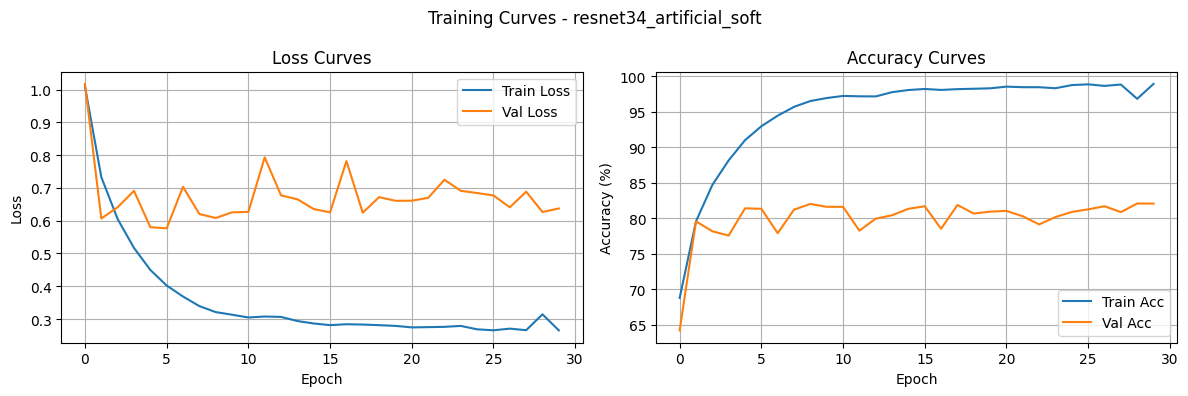


Test Loss: 0.6413
Test Accuracy: 82.00%
Macro AUPRC: 0.8828
{'airplane': {'precision': 0.85, 'recall': 0.864406779661017, 'f1-score': 0.8571428571428571, 'support': 767.0}, 'automobile': {'precision': 0.8483412322274881, 'recall': 0.9250645994832042, 'f1-score': 0.8850432632880099, 'support': 774.0}, 'bird': {'precision': 0.7649350649350649, 'recall': 0.7801324503311259, 'f1-score': 0.7724590163934426, 'support': 755.0}, 'cat': {'precision': 0.6652110625909753, 'recall': 0.6391608391608392, 'f1-score': 0.651925820256776, 'support': 715.0}, 'deer': {'precision': 0.7888748419721872, 'recall': 0.8041237113402062, 'f1-score': 0.7964262922782387, 'support': 776.0}, 'dog': {'precision': 0.7925117004680188, 'recall': 0.6666666666666666, 'f1-score': 0.7241625089094796, 'support': 762.0}, 'frog': {'precision': 0.8104838709677419, 'recall': 0.8751814223512336, 'f1-score': 0.8415910676901605, 'support': 689.0}, 'horse': {'precision': 0.8640776699029126, 'recall': 0.8534246575342466, 'f1-score': 

In [7]:
print("\n=== Running Main Experiment ===")
print("Training with artificial soft labels + CIFAR-10H")

# Load soft label predictor model
soft_label_model = ImageHardToSoftLabelModel().to(device)
soft_label_model.load_state_dict(torch.load("models/soft_label_model.pt", weights_only=True))
soft_label_model.eval()

# Generate artificial soft labels for augment dataset
augmented_soft_dataset = create_soft_label_dataset(soft_label_model, augment_loader, device)
cifar10h_soft_dataset = CIFAR10LabelDataset(train_dataset, cifar10h_probs)

# Combine datasets and create loader
combined_soft_dataset = ConcatDataset([augmented_soft_dataset, cifar10h_soft_dataset])
combined_soft_loader = DataLoader(combined_soft_dataset, batch_size=batch_size, shuffle=True)

print(f"Combined soft dataset size: {len(combined_soft_dataset)} samples")
print(f"- Augmented soft labels: {len(augmented_soft_dataset)} samples")
print(f"- CIFAR-10H soft labels: {len(cifar10h_soft_dataset)} samples")

# Train model
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model, metrics = train_model(
    model=model,
    train_loader=combined_soft_loader,
    val_loader=val_loader,
    num_epochs=30,
    device=device,
    model_name="resnet34_artificial_soft"
)

# Evaluate and save metrics for main experiment
model_metrics = evaluate_metrics(model, test_loader, device)
all_metrics['artificial_soft'] = {
    **metrics,  # Training metrics
    **model_metrics  # Test metrics
}
save_metrics(all_metrics['artificial_soft'], 'artificial_soft')


=== Running Baseline 1 ===
Training with CIFAR-10 hard labels + CIFAR-10H hard labels
Combined hard dataset size: 45000 samples
- Augment hard labels: 35000 samples
- CIFAR-10H hard labels: 10000 samples
Training on cuda
Epoch [1/30] Train Loss: 0.9104, Val Loss: 0.8881, Train Acc: 68.64%, Val Acc: 70.52%
Saved model with improved validation accuracy: 70.52%
Epoch [2/30] Train Loss: 0.5891, Val Loss: 0.6916, Train Acc: 80.04%, Val Acc: 76.36%
Saved model with improved validation accuracy: 76.36%
Epoch [3/30] Train Loss: 0.4402, Val Loss: 0.5954, Train Acc: 85.12%, Val Acc: 80.01%
Saved model with improved validation accuracy: 80.01%
Epoch [4/30] Train Loss: 0.3612, Val Loss: 0.6732, Train Acc: 87.53%, Val Acc: 78.55%
Epoch [5/30] Train Loss: 0.2645, Val Loss: 0.7421, Train Acc: 90.76%, Val Acc: 78.36%
Epoch [6/30] Train Loss: 0.2118, Val Loss: 0.6994, Train Acc: 92.71%, Val Acc: 78.37%
Epoch [7/30] Train Loss: 0.1677, Val Loss: 0.7363, Train Acc: 94.15%, Val Acc: 80.32%
Saved model wi

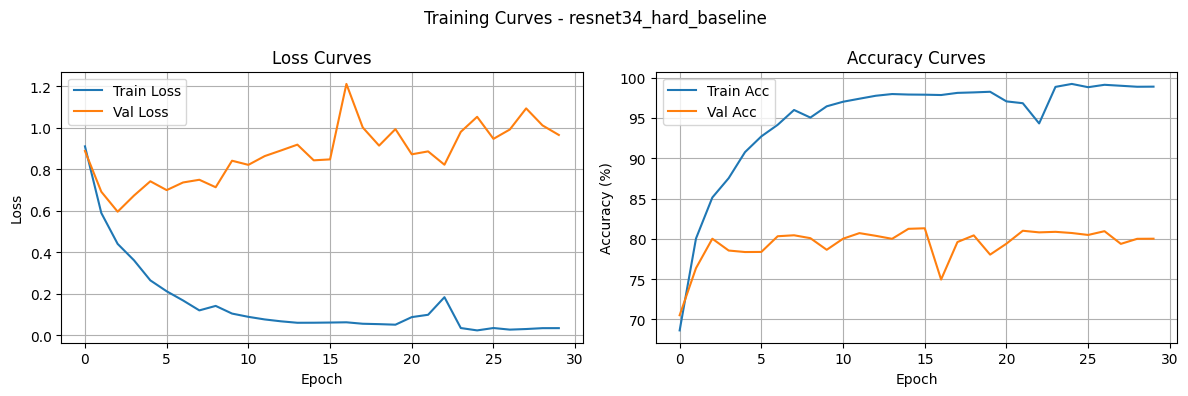


Test Loss: 1.0224
Test Accuracy: 78.56%
Macro AUPRC: 0.8710
{'airplane': {'precision': 0.7723669309173273, 'recall': 0.8891786179921773, 'f1-score': 0.8266666666666667, 'support': 767.0}, 'automobile': {'precision': 0.9099462365591398, 'recall': 0.8746770025839793, 'f1-score': 0.8919631093544137, 'support': 774.0}, 'bird': {'precision': 0.7300131061598951, 'recall': 0.7377483443708609, 'f1-score': 0.7338603425559947, 'support': 755.0}, 'cat': {'precision': 0.5517970401691332, 'recall': 0.73006993006993, 'f1-score': 0.6285370258880193, 'support': 715.0}, 'deer': {'precision': 0.8188622754491018, 'recall': 0.7048969072164949, 'f1-score': 0.7576177285318559, 'support': 776.0}, 'dog': {'precision': 0.6535532994923858, 'recall': 0.6758530183727034, 'f1-score': 0.6645161290322581, 'support': 762.0}, 'frog': {'precision': 0.8924914675767918, 'recall': 0.7590711175616836, 'f1-score': 0.8203921568627451, 'support': 689.0}, 'horse': {'precision': 0.847672778561354, 'recall': 0.8232876712328767,

In [8]:
print("\n=== Running Baseline 1 ===")
print("Training with CIFAR-10 hard labels + CIFAR-10H hard labels")

# Create combined hard label dataset
combined_hard_dataset = ConcatDataset([augment_dataset, train_dataset])
combined_hard_loader = DataLoader(combined_hard_dataset, batch_size=batch_size, shuffle=True)

print(f"Combined hard dataset size: {len(combined_hard_dataset)} samples")
print(f"- Augment hard labels: {len(augment_dataset)} samples")
print(f"- CIFAR-10H hard labels: {len(train_dataset)} samples")

model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model, metrics = train_model(
    model=model,
    train_loader=combined_hard_loader,
    val_loader=val_loader,
    num_epochs=30,
    device=device,
    model_name="resnet34_hard_baseline"
)

# Evaluate and save metrics for baseline 1
model_metrics = evaluate_metrics(model, test_loader, device)
all_metrics['hard_baseline'] = {
    **metrics,  # Training metrics
    **model_metrics  # Test metrics
}
save_metrics(all_metrics['hard_baseline'], 'hard_baseline')


=== Running Baseline 2 ===
Training with CIFAR-10 hard labels + CIFAR-10H soft labels
Combined mixed dataset size: 45000 samples
- Augment hard labels: 35000 samples
- CIFAR-10H soft labels: 10000 samples
Training on cuda
Epoch [1/30] Train Loss: 0.9058, Val Loss: 0.7150, Train Acc: 69.35%, Val Acc: 76.11%
Saved model with improved validation accuracy: 76.11%
Epoch [2/30] Train Loss: 0.5941, Val Loss: 0.8297, Train Acc: 80.54%, Val Acc: 72.00%
Epoch [3/30] Train Loss: 0.4530, Val Loss: 0.6184, Train Acc: 85.49%, Val Acc: 79.07%
Saved model with improved validation accuracy: 79.07%
Epoch [4/30] Train Loss: 0.3548, Val Loss: 0.6059, Train Acc: 89.04%, Val Acc: 80.63%
Saved model with improved validation accuracy: 80.63%
Epoch [5/30] Train Loss: 0.2804, Val Loss: 0.7830, Train Acc: 91.78%, Val Acc: 76.44%
Epoch [6/30] Train Loss: 0.2265, Val Loss: 0.6811, Train Acc: 93.57%, Val Acc: 79.69%
Epoch [7/30] Train Loss: 0.1910, Val Loss: 0.7399, Train Acc: 95.00%, Val Acc: 78.92%
Epoch [8/30] 

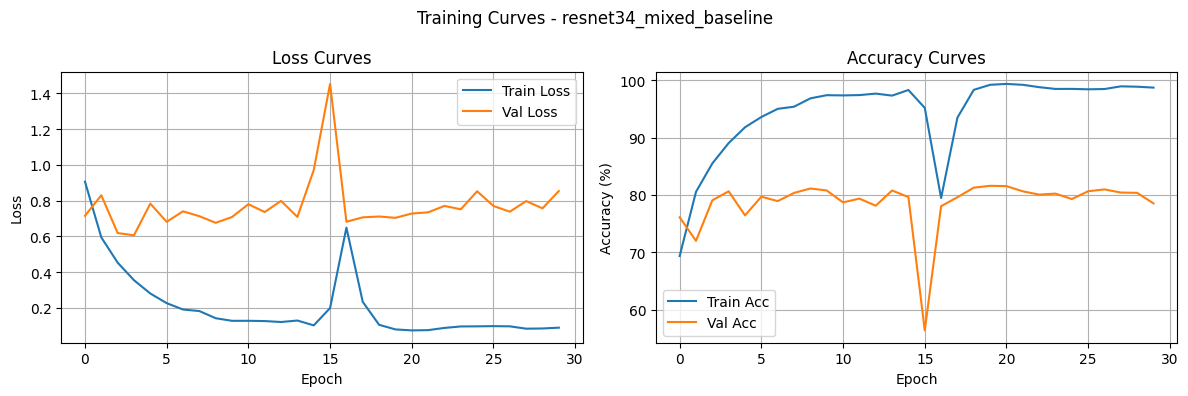


Test Loss: 0.8351
Test Accuracy: 78.00%
Macro AUPRC: 0.8639
{'airplane': {'precision': 0.7651006711409396, 'recall': 0.8917861799217731, 'f1-score': 0.8236002408187839, 'support': 767.0}, 'automobile': {'precision': 0.8958333333333334, 'recall': 0.8888888888888888, 'f1-score': 0.8923476005188068, 'support': 774.0}, 'bird': {'precision': 0.7544338335607094, 'recall': 0.7324503311258278, 'f1-score': 0.7432795698924731, 'support': 755.0}, 'cat': {'precision': 0.5045955882352942, 'recall': 0.7678321678321678, 'f1-score': 0.6089850249584027, 'support': 715.0}, 'deer': {'precision': 0.8050595238095238, 'recall': 0.6971649484536082, 'f1-score': 0.7472375690607734, 'support': 776.0}, 'dog': {'precision': 0.7310664605873262, 'recall': 0.6207349081364829, 'f1-score': 0.6713981547196594, 'support': 762.0}, 'frog': {'precision': 0.8020086083213773, 'recall': 0.8113207547169812, 'f1-score': 0.8066378066378066, 'support': 689.0}, 'horse': {'precision': 0.8809891808346213, 'recall': 0.78082191780821

In [9]:
print("\n=== Running Baseline 2 ===")
print("Training with CIFAR-10 hard labels + CIFAR-10H soft labels")

# Create mixed dataset (hard + soft labels)
hard_label_dataset = CIFAR10LabelDataset(augment_dataset)
soft_label_dataset = CIFAR10LabelDataset(train_dataset, cifar10h_probs)
combined_mixed_dataset = ConcatDataset([hard_label_dataset, soft_label_dataset])
combined_mixed_loader = DataLoader(combined_mixed_dataset, batch_size=batch_size, shuffle=True)

print(f"Combined mixed dataset size: {len(combined_mixed_dataset)} samples")
print(f"- Augment hard labels: {len(hard_label_dataset)} samples")
print(f"- CIFAR-10H soft labels: {len(soft_label_dataset)} samples")

model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model, metrics = train_model(
    model=model,
    train_loader=combined_mixed_loader,
    val_loader=val_loader,
    num_epochs=30,
    device=device,
    model_name="resnet34_mixed_baseline"
)

# Evaluate and save metrics for baseline 2
model_metrics = evaluate_metrics(model, test_loader, device)
all_metrics['mixed_baseline'] = {
    **metrics,  # Training metrics
    **model_metrics  # Test metrics
}
save_metrics(all_metrics['mixed_baseline'], 'mixed_baseline')

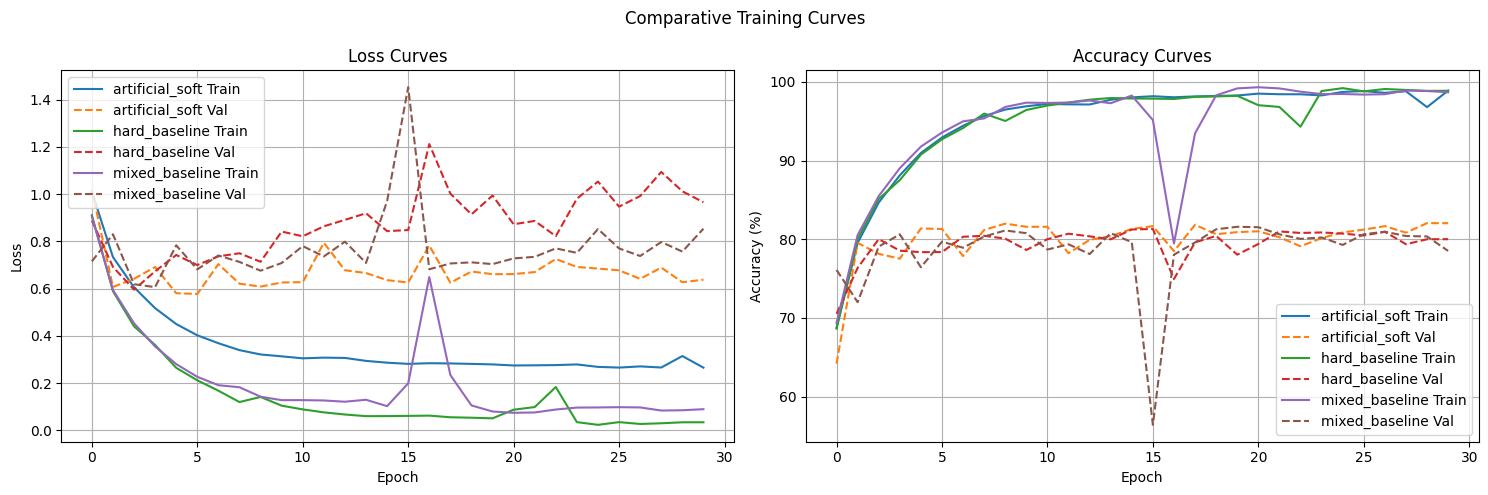


=== Comparative Results ===

artificial_soft:
Test Accuracy: 82.00%
Macro AUPRC: 0.8828
Per-class AUPRC:
  airplane: 0.9138
  automobile: 0.9567
  bird: 0.8400
  cat: 0.7144
  deer: 0.8380
  dog: 0.8174
  frog: 0.9212
  horse: 0.9265
  ship: 0.9532
  truck: 0.9470

hard_baseline:
Test Accuracy: 78.56%
Macro AUPRC: 0.8710
Per-class AUPRC:
  airplane: 0.9195
  automobile: 0.9481
  bird: 0.8239
  cat: 0.7074
  deer: 0.8614
  dog: 0.7600
  frog: 0.9077
  horse: 0.9118
  ship: 0.9350
  truck: 0.9352

mixed_baseline:
Test Accuracy: 78.00%
Macro AUPRC: 0.8639
Per-class AUPRC:
  airplane: 0.9052
  automobile: 0.9479
  bird: 0.8311
  cat: 0.6905
  deer: 0.8335
  dog: 0.7655
  frog: 0.8880
  horse: 0.9080
  ship: 0.9335
  truck: 0.9362


In [10]:
# Plot comparative curves
plot_comparative_curves(all_metrics)

# Print comparative metrics
print("\n=== Comparative Results ===")
for model_name, metrics in all_metrics.items():
    print(f"\n{model_name}:")
    print(f"Test Accuracy: {metrics['test_accuracy']:.2f}%")
    print(f"Macro AUPRC: {metrics['macro_auprc']:.4f}")
    print("Per-class AUPRC:")
    for class_name in CIFAR10_CLASSES:
        print(f"  {class_name}: {metrics[f'class_{class_name}_auprc']:.4f}")

In [11]:
# Load saved metrics
metrics_dir = "metrics"
all_loaded_metrics = {}

for model_name in ['hard_baseline', 'mixed_baseline', 'artificial_soft']:
    metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
    with open(metrics_path, 'r') as f:
        all_loaded_metrics[model_name] = json.load(f)

print(all_loaded_metrics.keys())
for model_name, metrics in all_loaded_metrics.items():
    print(f"\n{model_name}:")
    print(metrics)

dict_keys(['hard_baseline', 'mixed_baseline', 'artificial_soft'])

hard_baseline:
{'train_loss': [0.9103561067445711, 0.5891211325810715, 0.44023081656037405, 0.3612247956070033, 0.26445121519182896, 0.2118356360059062, 0.16770258476026356, 0.11969934905540537, 0.14135265129152685, 0.10437487106537446, 0.08864657723196698, 0.07610417522796938, 0.06700134546289602, 0.06004100572185549, 0.060265284050150185, 0.06113585730649489, 0.0622901464296526, 0.055316229300594634, 0.053423470263210635, 0.050785395861814984, 0.0873396965272894, 0.09857961878614416, 0.18333534068435917, 0.034666738127932396, 0.02327355043846844, 0.03472957773969525, 0.027003867178791552, 0.02989698640158167, 0.03405743923477447, 0.034162482633374486], 'train_acc': [68.63777777777777, 80.04, 85.12444444444445, 87.52666666666667, 90.75777777777778, 92.71111111111111, 94.14666666666666, 95.98444444444445, 95.04222222222222, 96.44, 97.00666666666666, 97.38222222222223, 97.74888888888889, 97.96222222222222, 97.9, 97.88222

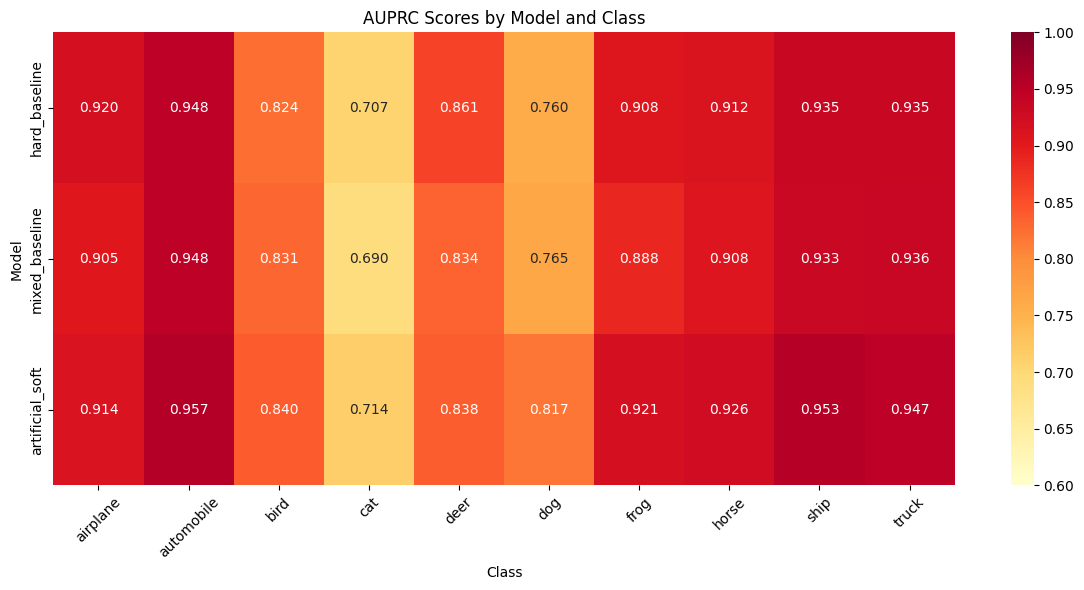

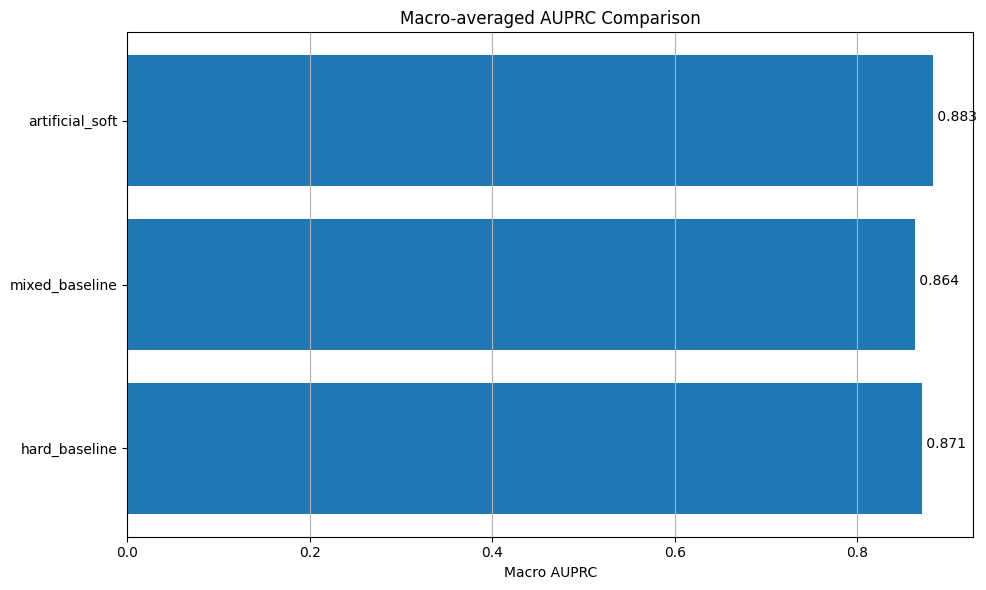

In [17]:
# Create a heatmap comparing AUPRC scores across models and classes
plt.figure(figsize=(12, 6))

# Create matrix of AUPRC values
model_names = list(all_loaded_metrics.keys())
auprc_matrix = []

for model_name in model_names:
    model_auprcs = []
    for class_name in CIFAR10_CLASSES:
        auprc = all_loaded_metrics[model_name][f'class_{class_name}_auprc']
        model_auprcs.append(auprc)
    auprc_matrix.append(model_auprcs)

# Create heatmap
sns.heatmap(auprc_matrix, 
            annot=True, 
            fmt='.3f',
            xticklabels=CIFAR10_CLASSES,
            yticklabels=model_names,
            cmap='YlOrRd',
            vmin=0.6,
            vmax=1.0)

plt.title('AUPRC Scores by Model and Class')
plt.xlabel('Class')
plt.ylabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot macro AUPRC comparison
plt.figure(figsize=(10, 6))
macro_auprcs = [metrics['macro_auprc'] for metrics in all_loaded_metrics.values()]

# Create horizontal bar chart
y_pos = np.arange(len(model_names))
plt.barh(y_pos, macro_auprcs)
plt.yticks(y_pos, model_names)

# Add value labels on bars
for i, v in enumerate(macro_auprcs):
    plt.text(v, i, f' {v:.3f}')

plt.title('Macro-averaged AUPRC Comparison')
plt.xlabel('Macro AUPRC')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()